In [ ]:
## making my own AHRS filter 

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy import integrate
from scipy import linalg
from scipy import interpolate
from scipy import optimize
from scipy import stats
from scipy import fftpack
from scipy import io
from scipy import constants

In [7]:
Ts = 0.01 # 100 Hz
P = np.array([[100,0,0],[0,100,0],[0,0,100]]) # initial covariance matrix
T = 50 # simulation time
t = np.arange(0,T,Ts) # time vector
P_array = np.zeros((3,3,len(t))) # covariance matrix array
Q = np.array([[0.1,0,0],[0,0.1,0],[0,0,0.1]])*1 # process noise covariance matrix
R = np.array([[0.01,0,0],[0,0.01,0],[0,0,0.01]])*1 # measurement noise covariance matrix
accel = pd.read_csv('acc.csv',header=None) # accelerometer data
accel.columns = ['time','ax','ay','az']
gyro = pd.read_csv('gyro.csv',header=None) # gyroscope data
gyro.columns = ['time','wx','wy','wz']
mag = pd.read_csv('mag.csv',header=None) # magnetometer data
mag.columns = ['time','mx','my','mz']
## init variables
x = np.zeros((3,len(t))) # state vector
x[:,0] = np.array([0,0,0]) # initial state
delta_x = np.zeros((3,len(t))) # state error vector
z = np.zeros((3,len(t))) # measurement vector
z[:,0] = np.array([0,0,0]) # initial measurement
x_prop = np.zeros((3,len(t))) # propagated state vector
# constants
g = 9.81 # gravity
# add noise to measurements
accel['ax'] = accel['ax'] + np.random.normal(0,R[0,0],len(accel['ax']))
accel['ay'] = accel['ay'] + np.random.normal(0,R[1,1],len(accel['ay']))
accel['az'] = accel['az'] + np.random.normal(0,R[2,2],len(accel['az']))
gyro['wx'] = gyro['wx'] + np.random.normal(0,R[0,0],len(gyro['wx']))
gyro['wy'] = gyro['wy'] + np.random.normal(0,R[1,1],len(gyro['wy']))
gyro['wz'] = gyro['wz'] + np.random.normal(0,R[2,2],len(gyro['wz']))
# add exp(0.01t) bias to gyro
gyro['wx'] = gyro['wx'] + np.exp(0.01*gyro['time'])
gyro['wy'] = gyro['wy'] + np.exp(0.01*gyro['time'])
gyro['wz'] = gyro['wz'] + np.exp(0.01*gyro['time'])

# load true data
true = pd.read_csv('true.csv',header=None)
true.columns = ['time','phi','theta','psi']


In [8]:
## train data is a ten sequential measurements
# function make train data with 10 sequence
def make_train_data(x_train, sequence_length):
    x_result = []
    for index in range(len(x_train) - sequence_length):
        x_result.append(x_train[index: index + sequence_length])
    return np.array(x_result)
def make_train_data_delay(x_train, sequence_length):
    x_result = []
    for index in range(len(x_train) - sequence_length):
        x_result.append(x_train[index])
    return np.array(x_result)

# x_accel = np.array([accel['ax'],accel['ay'],accel['az']])
# x_gyro = np.array([gyro['wx'],gyro['wy'],gyro['wz']],gyro['time'])
# x_mag = np.array([mag['mx'],mag['my'],mag['mz']])
# x_true = np.array([true['phi'],true['theta'],true['psi']])


# x_accel = make_train_data(x_accel,10)
# x_gyro = make_train_data(x_gyro,10)
# x_mag = make_train_data(x_mag,10)
# x_true = make_train_data(x_true,10)

a_x = accel['ax'].to_numpy()*100
a_y = accel['ay'].to_numpy()*100
a_z = (accel['az'].to_numpy()+9.8)*100
w_x = gyro['wx'].to_numpy()
w_y = gyro['wy'].to_numpy()
w_z = gyro['wz'].to_numpy()
m_x = mag['mx'].to_numpy()/10000
m_y = mag['my'].to_numpy()/10000
m_z = mag['mz'].to_numpy()/10000
phi = true['phi'].to_numpy()*100
theta = true['theta'].to_numpy()*100
psi = true['psi'].to_numpy()*100
time = accel['time'].to_numpy()



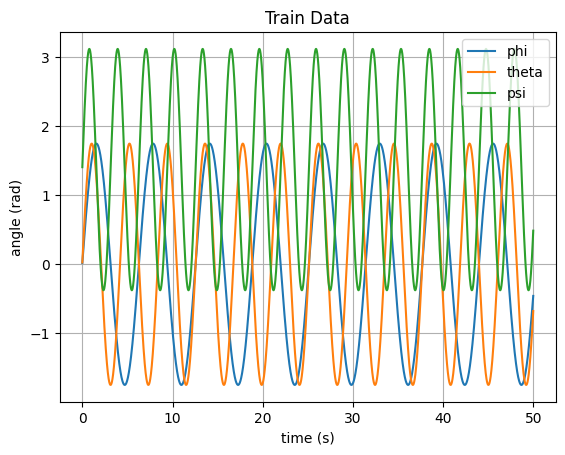

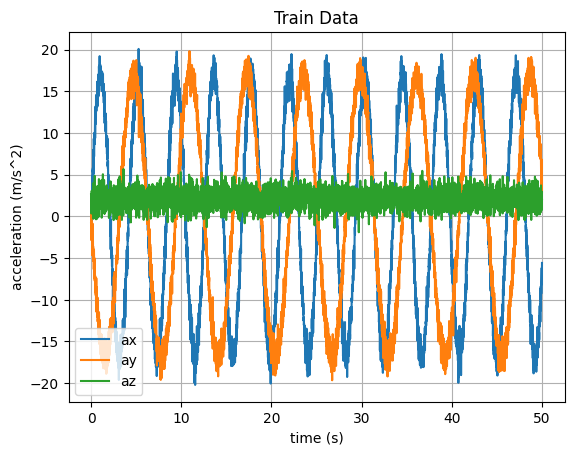

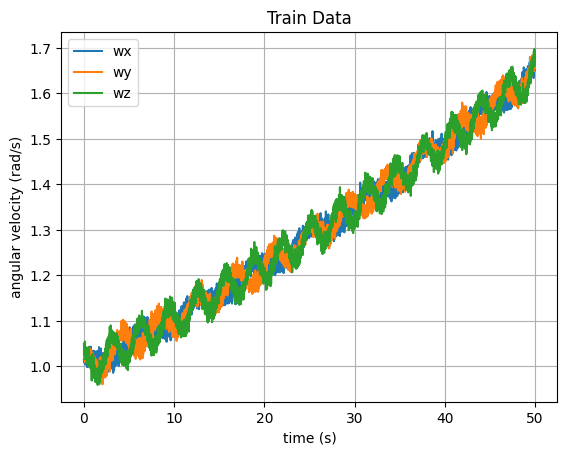

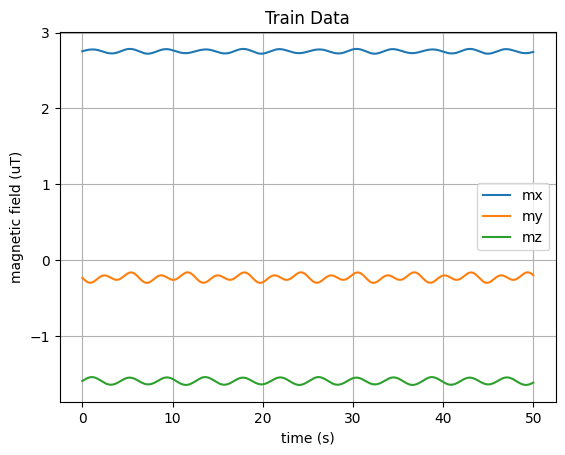

In [9]:
# plot train data
plt.figure()
plt.plot(time,phi)
plt.plot(time,theta)
plt.plot(time,psi)
plt.legend(['phi','theta','psi'])
plt.xlabel('time (s)')
plt.ylabel('angle (rad)')
plt.title('Train Data')
plt.grid()

plt.figure()
plt.plot(time,a_x)
plt.plot(time,a_y)
plt.plot(time,a_z)
plt.legend(['ax','ay','az'])
plt.xlabel('time (s)')
plt.ylabel('acceleration (m/s^2)')
plt.title('Train Data')
plt.grid()

plt.figure()
plt.plot(time,w_x)
plt.plot(time,w_y)
plt.plot(time,w_z)
plt.legend(['wx','wy','wz'])
plt.xlabel('time (s)')
plt.ylabel('angular velocity (rad/s)')
plt.title('Train Data')
plt.grid()

plt.figure()
plt.plot(time,m_x)
plt.plot(time,m_y)
plt.plot(time,m_z)
plt.legend(['mx','my','mz'])
plt.xlabel('time (s)')
plt.ylabel('magnetic field (uT)')
plt.title('Train Data')
plt.grid()




In [10]:
a_x = make_train_data(a_x,10)
a_y = make_train_data(a_y,10)
a_z = make_train_data(a_z,10)
w_x = make_train_data(w_x,10)
w_y = make_train_data(w_y,10)
w_z = make_train_data(w_z,10)
m_x = make_train_data(m_x,10)
m_y = make_train_data(m_y,10)
m_z = make_train_data(m_z,10)
phi = make_train_data_delay(phi,10)
theta = make_train_data_delay(theta,10)
psi = make_train_data_delay(psi,10)
phi = np.reshape(phi,(phi.shape[0],1))
theta = np.reshape(theta,(theta.shape[0],1))
psi = np.reshape(psi,(psi.shape[0],1))
time = accel['time'].to_numpy()
time = time[0:time.shape[0]-10]
time = np.reshape(time,(time.shape[0],1))

x_train_1 = np.concatenate((a_x,a_y,a_z),axis=1)
x_train_2 = np.concatenate((w_x,w_y,w_z),axis=1)
x_train_3 = np.concatenate((m_x,m_y,m_z),axis=1)
y_train = np.concatenate((phi,theta,psi),axis=1)

# to tensorflow data
x_train_1 = np.reshape(x_train_1,(x_train_1.shape[0],x_train_1.shape[1],1))
x_train_2 = np.reshape(x_train_2,(x_train_2.shape[0],x_train_2.shape[1],1))
x_train_3 = np.reshape(x_train_3,(x_train_3.shape[0],x_train_3.shape[1],1))
y_train = np.reshape(y_train,(y_train.shape[0],y_train.shape[1],1))
time = np.reshape(time,(time.shape[0],time.shape[1],1))




In [11]:
## make network :))))))))))))))
## make tensorflow lstm model ##
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers

2024-01-30 16:01:25.699848: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [55]:
def lstm_model(x_train, x_train1, x_train2, time, y_train):
    input1 = Input(shape=(x_train.shape[1],x_train.shape[2]))
    lstm1 = LSTM(32,return_sequences=True)(input1)
    input2 = Input(shape=(x_train1.shape[1],x_train1.shape[2]))
    lstm2 = LSTM(32,return_sequences=True)(input2)
    input3 = Input(shape=(x_train2.shape[1],x_train2.shape[2]))
    lstm3 = LSTM(32,return_sequences=True)(input3)
    input4 = Input(shape=(time.shape[1],time.shape[2]))
    lstm4 = LSTM(32,return_sequences=True)(input4)
    concat = concatenate([lstm1,lstm2,lstm3,lstm4], axis=1)
    lstm5 = LSTM(32)(concat)
    output = Dense(3)(lstm5)
    model = Model(inputs=[input1,input2,input3,input4],outputs=output)
    return model

model = lstm_model(x_train_1,x_train_2,x_train_3,time,y_train)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 30, 1)]              0         []                            
                                                                                                  
 input_10 (InputLayer)       [(None, 30, 1)]              0         []                            
                                                                                                  
 input_11 (InputLayer)       [(None, 30, 1)]              0         []                            
                                                                                                  
 input_12 (InputLayer)       [(None, 1, 1)]               0         []                            
                                                                                            

In [60]:
model.summary()
# plot model
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 30, 1)]              0         []                            
                                                                                                  
 input_10 (InputLayer)       [(None, 30, 1)]              0         []                            
                                                                                                  
 input_11 (InputLayer)       [(None, 30, 1)]              0         []                            
                                                                                                  
 input_12 (InputLayer)       [(None, 1, 1)]               0         []                            
                                                                                            

In [61]:
# compile model
model.compile(loss='mse', optimizer='adam', metrics=['mse'])


In [62]:
# callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
filename = 'model_part1.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

In [65]:
# fit model
history = model.fit([x_train_1,x_train_2,x_train_3,time], y_train, epochs=100, batch_size=64, validation_split=0.2, callbacks=[early_stop, checkpoint], verbose=1)


Epoch 1/100
63/63 [==============================] - ETA: 0s - loss: 1.6756e-04 - mse: 1.6756e-04
Epoch 1: val_loss improved from inf to 0.00018, saving model to model_part1.h5
63/63 [==============================] - 22s 345ms/step - loss: 1.6756e-04 - mse: 1.6756e-04 - val_loss: 1.8388e-04 - val_mse: 1.8388e-04
Epoch 2/100


/Users/Ali/Library/Python/3.11/lib/python/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


63/63 [==============================] - ETA: 0s - loss: 1.6136e-04 - mse: 1.6136e-04
Epoch 2: val_loss improved from 0.00018 to 0.00016, saving model to model_part1.h5
63/63 [==============================] - 13s 210ms/step - loss: 1.6136e-04 - mse: 1.6136e-04 - val_loss: 1.6320e-04 - val_mse: 1.6320e-04
Epoch 3/100
63/63 [==============================] - ETA: 0s - loss: 1.6931e-04 - mse: 1.6931e-04
Epoch 3: val_loss improved from 0.00016 to 0.00015, saving model to model_part1.h5
63/63 [==============================] - 13s 212ms/step - loss: 1.6931e-04 - mse: 1.6931e-04 - val_loss: 1.5331e-04 - val_mse: 1.5331e-04
Epoch 4/100
63/63 [==============================] - ETA: 0s - loss: 1.6183e-04 - mse: 1.6183e-04
Epoch 4: val_loss did not improve from 0.00015
63/63 [==============================] - 13s 207ms/step - loss: 1.6183e-04 - mse: 1.6183e-04 - val_loss: 1.8043e-04 - val_mse: 1.8043e-04
Epoch 5/100
63/63 [==============================] - ETA: 0s - loss: 1.6218e-04 - mse: 1.62

In [12]:
# load model
model = keras.models.load_model('model_part1.h5')

156/156 [==============================] - 5s 13ms/step


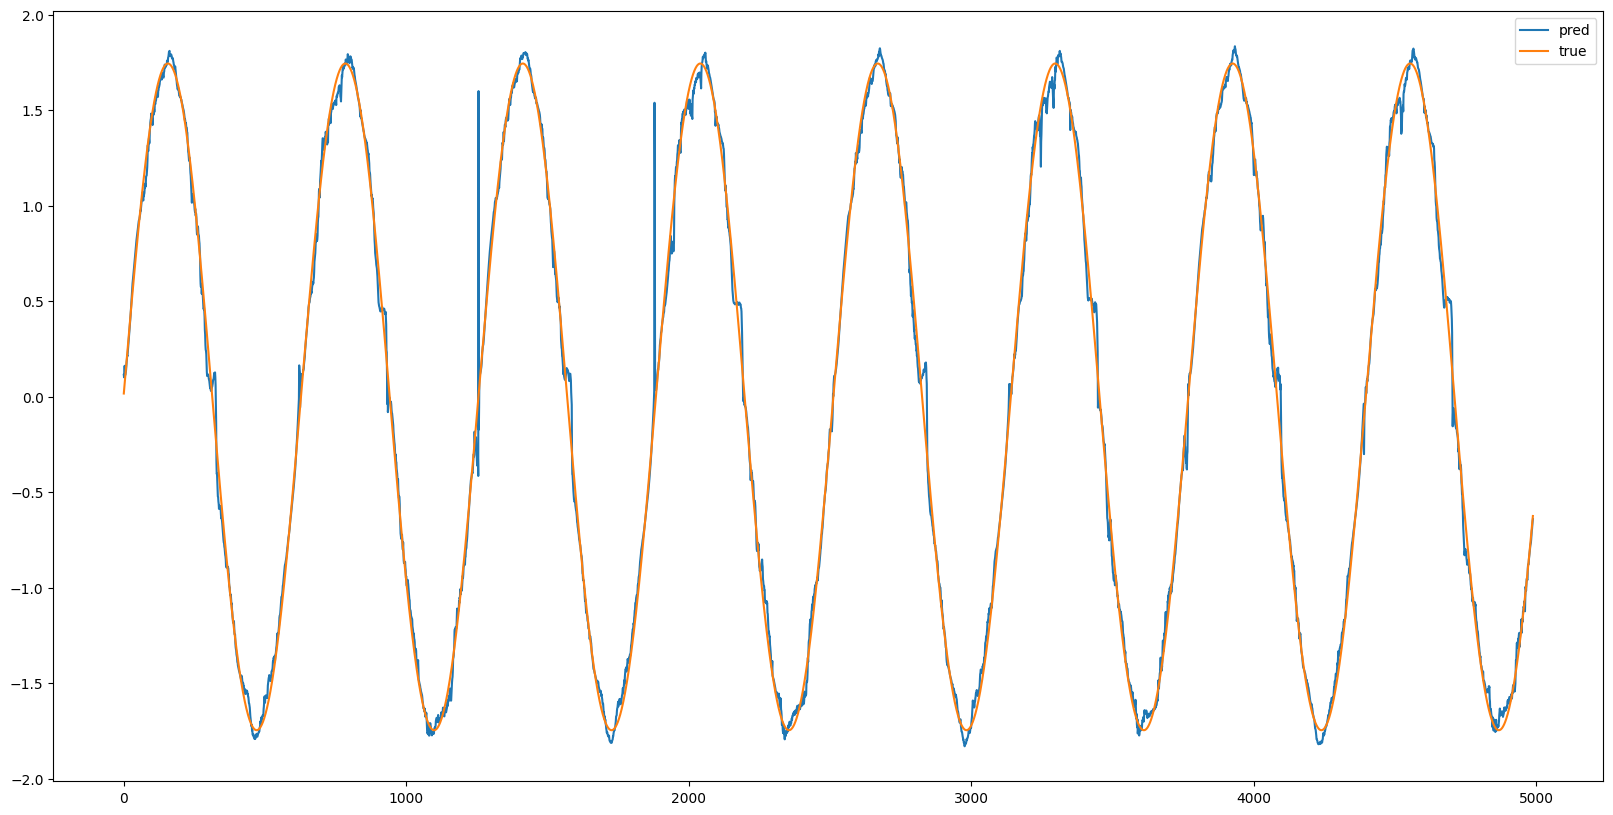

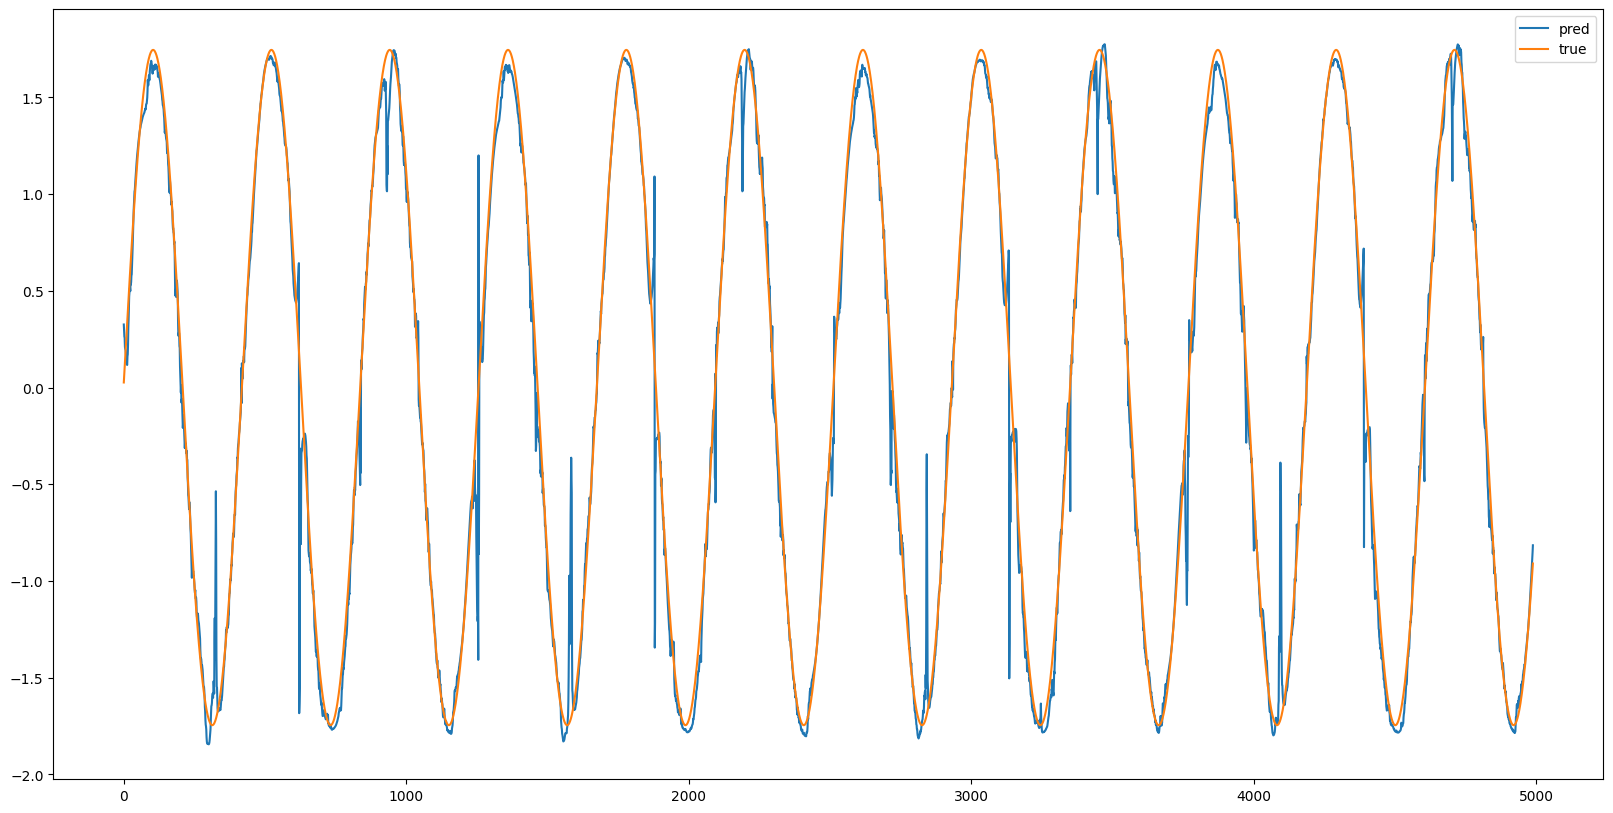

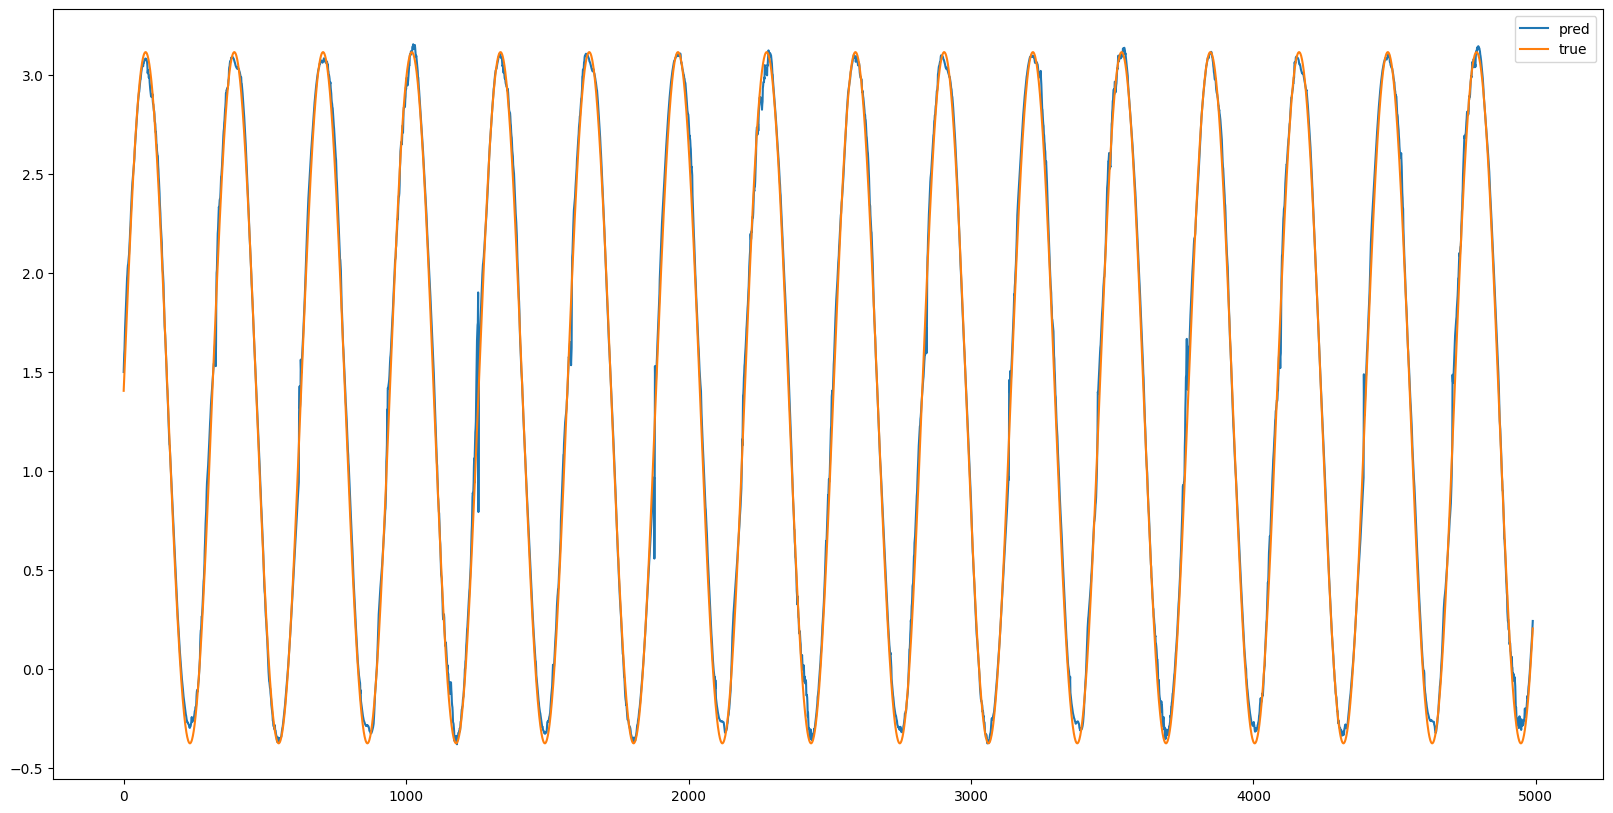

In [10]:
# test results
x_pred = model.predict([x_train_1,x_train_2,x_train_3,time])
# plot results
plt.figure(figsize=(20,10))
plt.plot(x_pred[:,0],label='pred')
plt.plot(y_train[:,0],label='true')
plt.legend()
# save figure
plt.savefig('phi.png')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(x_pred[:,1],label='pred')
plt.plot(y_train[:,1],label='true')
plt.legend()
plt.savefig('theta.png')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(x_pred[:,2],label='pred')
plt.plot(y_train[:,2],label='true')
plt.legend()
plt.savefig('psi.png')
plt.show()


In [11]:
phi_meas = np.arctan2(-accel['ay'],-accel['az'])
theta_meas = np.arcsin(accel['ax']/g)
psi_meas = np.arctan2(-mag['my']*np.cos(phi_meas)+mag['mz']*np.sin(phi_meas), mag['mx']*np.cos(theta_meas) + mag['my']*np.sin(theta_meas)*np.sin(phi_meas) + mag['mz']*np.sin(theta_meas)*np.cos(phi_meas)) - 4.0266*np.pi/180
## using AI for prediction
phi_pred = x_pred[:,0]/100
theta_pred = x_pred[:,1]/100
psi_pred = x_pred[:,2]/100

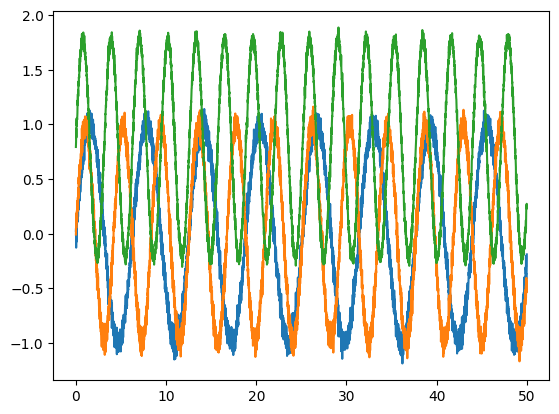

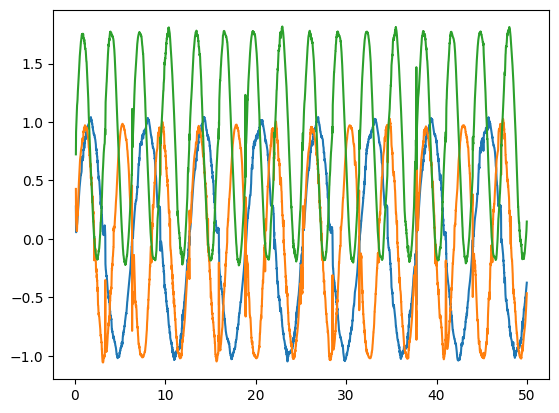

In [97]:
plt.figure()
plt.plot(t,phi_meas*180/np.pi)
plt.plot(t,theta_meas*180/np.pi)
plt.plot(t,psi_meas*180/np.pi)
plt.show()

plt.figure()
plt.plot(t[10:],phi_pred*180/np.pi)
plt.plot(t[10:],theta_pred*180/np.pi)
plt.plot(t[10:],psi_pred*180/np.pi)
plt.show()

In [43]:
time = accel['time'].to_numpy()
for i in range(10,len(time)-10):
    # propagate state
    phi = x_prop[0,i]
    theta = x_prop[1,i]
    psi = x_prop[2,i]
    x_prop[0, i+1] = phi + Ts*(gyro['wx'][i] + gyro['wy'][i]*np.sin(phi)*np.tan(theta) + gyro['wz'][i]*np.cos(phi)*np.tan(theta))
    x_prop[1, i+1] = theta + Ts*(gyro['wy'][i]*np.cos(phi) - gyro['wz'][i]*np.sin(phi))
    x_prop[2, i+1] = psi + Ts*(gyro['wy'][i]*np.sin(phi)/np.cos(theta) + gyro['wz'][i]*np.cos(phi)/np.cos(theta))
    # measurement update
    phi_meas = np.arctan2(-accel['ay'][i],-accel['az'][i])
    theta_meas = np.arcsin(accel['ax'][i]/g)
    psi_meas = np.arctan2(-mag['my'][i]*np.cos(phi_meas)+mag['mz'][i]*np.sin(phi_meas), mag['mx'][i]*np.cos(theta_meas) + mag['my'][i]*np.sin(theta_meas)*np.sin(phi_meas) + mag['mz'][i]*np.sin(theta_meas)*np.cos(phi_meas)) - 4.0266*np.pi/180
    z[:,i+1] = np.array([phi_meas,theta_meas,psi_meas])
    # add AI for measurment
    t = time[i]
    delta_ym = z[:,i+1] - x_prop[:,i+1]
    # kalman filter
    p = gyro['wx'][i]
    q = gyro['wy'][i]
    r = gyro['wz'][i]
    F = [[1+Ts*np.tan(theta)*(q*np.cos(phi)-r*np.sin(phi)), Ts*(q*np.sin(phi)+r*np.cos(phi))/(np.cos(theta)**2), 0],[Ts*(-q*np.sin(phi)-r*np.cos(phi)), 1, 0],[Ts*(q*np.cos(phi)-r*np.sin(phi))/np.cos(theta), Ts*np.sin(theta)*(q*np.sin(phi)+r*np.cos(phi))/np.cos(theta), 1]]
    delta_x[:,i+1] = np.dot(F,delta_x[:,i])
    Gamma = [[Ts, Ts*np.tan(theta)*np.sin(phi), Ts*np.tan(theta)*np.cos(phi)],[0, Ts*np.cos(phi), -Ts*np.sin(phi)],[0, Ts*np.sin(phi)/np.cos(theta), Ts*np.cos(phi)/np.cos(theta)]]
    P = np.dot(np.dot(F,P),np.transpose(F)) + np.dot(np.dot(Gamma,Q),np.transpose(Gamma))
    H = [[1,0,0],[0,1,0],[0,0,1]]
    delta_y = np.dot(H,delta_x[:,i+1])
    K = np.dot(np.dot(P,np.transpose(H)),linalg.inv(np.dot(np.dot(H,P),np.transpose(H))+R))
    delta_x[:,i+1] = delta_x[:,i+1] + np.dot(K,delta_ym-delta_y)
    P = np.dot(np.dot((np.identity(3)-np.dot(K,H)),P), np.transpose(np.dot((np.identity(3)-np.dot(K,H)),P))) + np.dot(np.dot(K,R),np.transpose(K))
    x[:,i+1] = x_prop[:,i+1] + delta_x[:,i+1]
    P_array[:,:,i+1] = P


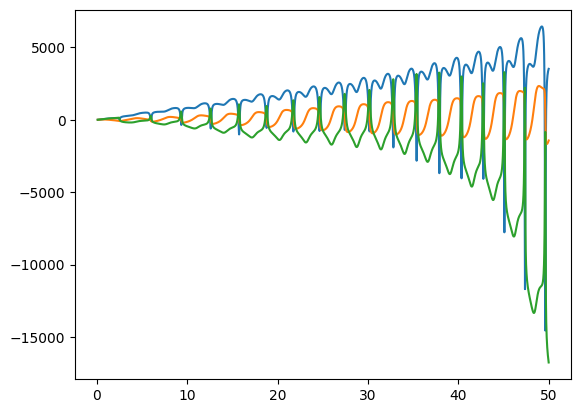

In [44]:
# plot data 
plt.figure()
plt.plot(time[10:],x[0,10:]*180/np.pi)
plt.plot(time[10:],x[1,10:]*180/np.pi)
plt.plot(time[10:],x[2,10:]*180/np.pi)

In [54]:
R = np.array([[0.01,0,0],[0,0.01,0],[0,0,0.01]])*0.000001 # measurement noise covariance matrix
time = accel['time'].to_numpy()
for i in range(10,len(time)-10):
    # propagate state
    phi = x_prop[0,i]
    theta = x_prop[1,i]
    psi = x_prop[2,i]
    x_prop[0, i+1] = phi + Ts*(gyro['wx'][i] + gyro['wy'][i]*np.sin(phi)*np.tan(theta) + gyro['wz'][i]*np.cos(phi)*np.tan(theta))
    x_prop[1, i+1] = theta + Ts*(gyro['wy'][i]*np.cos(phi) - gyro['wz'][i]*np.sin(phi))
    x_prop[2, i+1] = psi + Ts*(gyro['wy'][i]*np.sin(phi)/np.cos(theta) + gyro['wz'][i]*np.cos(phi)/np.cos(theta))
    # measurement update
    phi_meas = np.arctan2(-accel['ay'][i],-accel['az'][i])
    theta_meas = np.arcsin(accel['ax'][i]/g)
    psi_meas = np.arctan2(-mag['my'][i]*np.cos(phi_meas)+mag['mz'][i]*np.sin(phi_meas), mag['mx'][i]*np.cos(theta_meas) + mag['my'][i]*np.sin(theta_meas)*np.sin(phi_meas) + mag['mz'][i]*np.sin(theta_meas)*np.cos(phi_meas)) - 4.0266*np.pi/180
    x_1 = x_train_1[i]
    x_2 = x_train_2[i]
    x_3 = x_train_3[i]
    x_4 = time[i]
    x_1 = np.reshape(x_1,(1,x_1.shape[0],x_1.shape[1]))
    x_2 = np.reshape(x_2,(1,x_2.shape[0],x_2.shape[1]))
    x_3 = np.reshape(x_3,(1,x_3.shape[0],x_3.shape[1]))
    x_4 = np.reshape(x_4,(1,1))
    measurement_pred = model.predict([x_1,x_2,x_3,x_4])
    # z[:,i+1] = np.array([phi_meas,theta_meas,psi_meas])
    z[:,i+1] = measurement_pred[0]/100
    # add AI for measurment
    t = time[i]
    delta_ym = z[:,i+1] - x_prop[:,i+1]
    # kalman filter
    p = gyro['wx'][i]
    q = gyro['wy'][i]
    r = gyro['wz'][i]
    F = [[1+Ts*np.tan(theta)*(q*np.cos(phi)-r*np.sin(phi)), Ts*(q*np.sin(phi)+r*np.cos(phi))/(np.cos(theta)**2), 0],[Ts*(-q*np.sin(phi)-r*np.cos(phi)), 1, 0],[Ts*(q*np.cos(phi)-r*np.sin(phi))/np.cos(theta), Ts*np.sin(theta)*(q*np.sin(phi)+r*np.cos(phi))/np.cos(theta), 1]]
    delta_x[:,i+1] = np.dot(F,delta_x[:,i])
    Gamma = [[Ts, Ts*np.tan(theta)*np.sin(phi), Ts*np.tan(theta)*np.cos(phi)],[0, Ts*np.cos(phi), -Ts*np.sin(phi)],[0, Ts*np.sin(phi)/np.cos(theta), Ts*np.cos(phi)/np.cos(theta)]]
    P = np.dot(np.dot(F,P),np.transpose(F)) + np.dot(np.dot(Gamma,Q),np.transpose(Gamma))
    H = [[1,0,0],[0,1,0],[0,0,1]]
    delta_y = np.dot(H,delta_x[:,i+1])
    K = np.dot(np.dot(P,np.transpose(H)),linalg.inv(np.dot(np.dot(H,P),np.transpose(H))+R))
    delta_x[:,i+1] = delta_x[:,i+1] + np.dot(K,delta_ym-delta_y)
    P = np.dot(np.dot((np.identity(3)-np.dot(K,H)),P), np.transpose(np.dot((np.identity(3)-np.dot(K,H)),P))) + np.dot(np.dot(K,R),np.transpose(K))
    x[:,i+1] = x_prop[:,i+1] + delta_x[:,i+1]
    P_array[:,:,i+1] = P


1/1 [==============================] - 0s 38ms/step


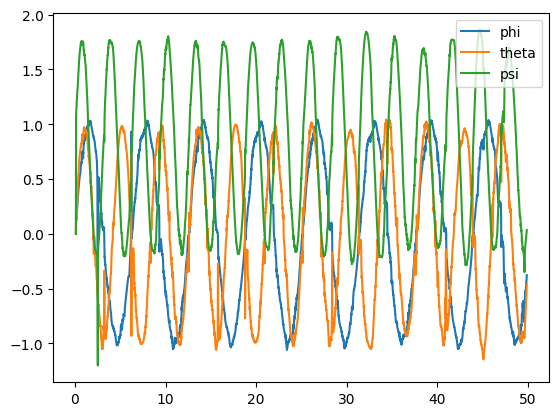

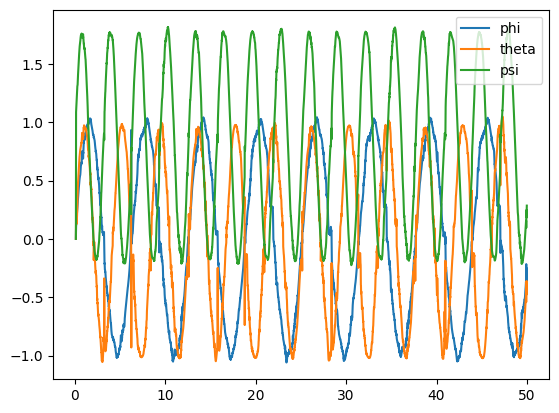

In [55]:
# plot data 
plt.figure()
plt.plot(time[10:-10],x[0,10:-10]*180/np.pi)
plt.plot(time[10:-10],x[1,10:-10]*180/np.pi)
plt.plot(time[10:-10],x[2,10:-10]*180/np.pi)
plt.legend(['phi','theta','psi'])
plt.show()
# plot measurment
plt.figure()
plt.plot(time[10:],z[0,10:]*180/np.pi)
plt.plot(time[10:],z[1,10:]*180/np.pi)
plt.plot(time[10:],z[2,10:]*180/np.pi)
plt.legend(['phi','theta','psi'])
plt.show()

In [99]:
# load model tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import activations
from tensorflow.keras import initializers
from tensorflow.keras import callbacks
from tensorflow.keras import backend as K
from tensorflow.keras import utils
from tensorflow.keras import models
from tensorflow.keras import preprocessing
from tensorflow.keras import applications
from tensorflow.keras import datasets

# load model
model = models.load_model('model.h5')

In [100]:
# use model to predict kalman ahrs measurements
x_kalman = np.zeros((3,len(t))) 
x_kalman[:,0] = np.array([0,0,0]) # initial state

for i in range(len(t)-1):
    # propagate state
    phi = x_prop[0,i]
    theta = x_prop[1,i]
    psi = x_prop[2,i]
    x_prop[0, i+1] = phi + Ts*(gyro['wx'][i] + gyro['wy'][i]*np.sin(phi)*np.tan(theta) + gyro['wz'][i]*np.cos(phi)*np.tan(theta))
    x_prop[1, i+1] = theta + Ts*(gyro['wy'][i]*np.cos(phi) - gyro['wz'][i]*np.sin(phi))
    x_prop[2, i+1] = psi + Ts*(gyro['wy'][i]*np.sin(phi)/np.cos(theta) + gyro['wz'][i]*np.cos(phi)/np.cos(theta))
    # measurement update
    phi_meas = np.arctan2(-accel['ay'][i],-accel['az'][i])
    theta_meas = np.arcsin(accel['ax'][i]/g)
    psi_meas = np.arctan2(-mag['my'][i]*np.cos(phi_meas)+mag['mz'][i]*np.sin(phi_meas), mag['mx'][i]*np.cos(theta_meas) + mag['my'][i]*np.sin(theta_meas)*np.sin(phi_meas) + mag['mz'][i]*np.sin(theta_meas)*np.cos(phi_meas)) - 4.0266*np.pi/180

    # predict measurements from measurements and propagate state
    x_kalman[:,i+1] = model.predict(np.array([[phi_meas,theta_meas,psi_meas,phi,theta,psi]]))
    z[:,i+1] = x_kalman[:,i+1]
    delta_ym = z[:,i+1] - x_prop[:,i+1]
    # kalman filter
    p = gyro['wx'][i]
    q = gyro['wy'][i]
    r = gyro['wz'][i]
    F = [[1+Ts*np.tan(theta)*(q*np.cos(phi)-r*np.sin(phi)), Ts*(q*np.sin(phi)+r*np.cos(phi))/(np.cos(theta)**2), 0],[Ts*(-q*np.sin(phi)-r*np.cos(phi)), 1, 0],[Ts*(q*np.cos(phi)-r*np.sin(phi))/np.cos(theta), Ts*np.sin(theta)*(q*np.sin(phi)+r*np.cos(phi))/np.cos(theta), 1]]
    delta_x[:,i+1] = np.dot(F,delta_x[:,i])
    Gamma = [[Ts, Ts*np.tan(theta)*np.sin(phi), Ts*np.tan(theta)*np.cos(phi)],[0, Ts*np.cos(phi), -Ts*np.sin(phi)],[0, Ts*np.sin(phi)/np.cos(theta), Ts*np.cos(phi)/np.cos(theta)]]
    P = np.dot(np.dot(F,P),np.transpose(F)) + np.dot(np.dot(Gamma,Q),np.transpose(Gamma))
    H = [[1,0,0],[0,1,0],[0,0,1]]
    delta_y = np.dot(H,delta_x[:,i+1])
    K = np.dot(np.dot(P,np.transpose(H)),linalg.inv(np.dot(np.dot(H,P),np.transpose(H))+R))
    delta_x[:,i+1] = delta_x[:,i+1] + np.dot(K,delta_ym-delta_y)
    P = np.dot(np.dot((np.identity(3)-np.dot(K,H)),P), np.transpose(np.dot((np.identity(3)-np.dot(K,H)),P))) + np.dot(np.dot(K,R),np.transpose(K))
    x[:,i+1] = x_prop[:,i+1] + delta_x[:,i+1]
    P_array[:,:,i+1] = P

1/1 [==============================] - 0s 21ms/step


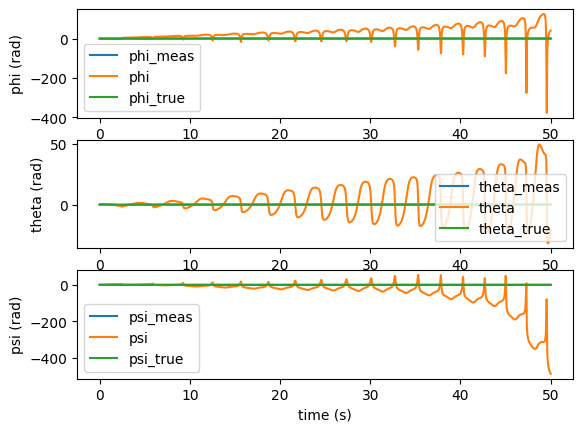

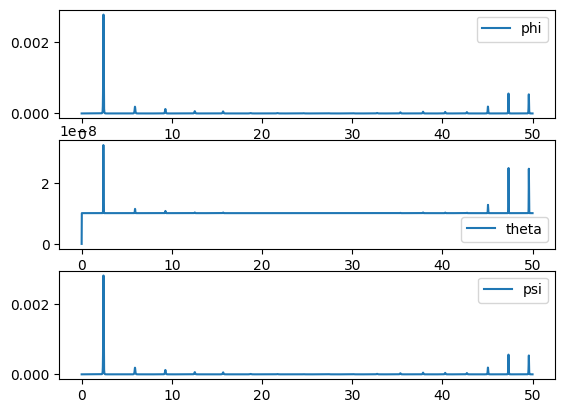

In [101]:
# load true data
true = pd.read_csv('true.csv',header=None)
true.columns = ['time','phi','theta','psi']


plt.figure()
plt.subplot(3,1,1)
plt.plot(t,z[0,:],label='phi_meas')
plt.plot(t,x[0,:],label='phi')
plt.plot(t,true['phi'],label='phi_true')
plt.xlabel('time (s)')
plt.ylabel('phi (rad)')
plt.legend()
plt.subplot(3,1,2)
plt.plot(t,z[1,:],label='theta_meas')
plt.plot(t,x[1,:],label='theta')
plt.plot(t,true['theta'],label='theta_true')
plt.xlabel('time (s)')
plt.ylabel('theta (rad)')
plt.legend()
plt.subplot(3,1,3)
plt.plot(t,z[2,:],label='psi_meas')
plt.plot(t,x[2,:],label='psi')
plt.plot(t,true['psi'],label='psi_true')
plt.xlabel('time (s)')
plt.ylabel('psi (rad)')
plt.legend()
plt.show()


# plot P
plt.figure()
plt.subplot(3,1,1)
plt.plot(t,P_array[0,0,:],label='phi')
plt.legend()
plt.subplot(3,1,2)
plt.plot(t,P_array[1,1,:],label='theta')
plt.legend()
plt.subplot(3,1,3)
plt.plot(t,P_array[2,2,:],label='psi')
plt.legend()
plt.show()